# Clasificación de Cobertura Forestal con MLP en PyTorch

## Introducción

En este proyecto construiremos, entrenaremos y evaluaremos un Perceptron Multicapa (MLP) para clasificar tipos de cobertura forestal utilizando el dataset CoverType. Este dataset contiene informacion cartográfica de áreas silvestres en el Roosevelt National Forest de Colorado, Estados Unidos.

El objetivo principal es alcanzar al menos un 93% de accuracy en el conjunto de prueba, lo cual requerirá una exploración cuidadosa de los datos, preprocesamiento adecuado y búsqueda de hiperparámetros.

## Workflow

1. Configuración del entorno y verificación de GPU
2. Carga y exploración del dataset
3. Preprocesamiento de datos
4. Creación del Dataset y DataLoaders de PyTorch
5. Construcción de la arquitectura MLP
6. Entrenamiento del modelo
7. Evaluación y análisis de resultados
8. Búsqueda de hiperparámetros con Optuna
9. Conclusiones y oportunidades de mejora

In [1]:
# Configuración e importación de librerías

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Verificación del entorno
print('Versiones del entorno:')
print(f'PyTorch: {torch.__version__}')
print(f'NumPy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print()
print('Configuración de GPU:')
print(f'CUDA disponible: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'Dispositivo: {torch.cuda.get_device_name(0)}')
    print(f'Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
    
# Definir dispositivo para entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nDispositivo de entrenamiento: {device}')

Versiones del entorno:
PyTorch: 2.9.0+cu130
NumPy: 2.3.5
Pandas: 2.3.3

Configuración de GPU:
CUDA disponible: True
Dispositivo: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Memoria total: 6.44 GB

Dispositivo de entrenamiento: cuda


## 1. Carga y Exploración del Dataset

El dataset CoverType proviene del UCI Machine Learning Repository y contiene 581,012 observaciones con 54 características. Cada observación representa una celda de 30x30 metros del bosque, y la tarea es predecir cuál de los 7 tipos de cobertura forestal corresponde a esa área.

Las características incluyen:
- Elevación, pendiente y aspecto del terreno
- Distancias horizontales y verticales a puntos de referencia (hidrología, carreteras, puntos de fuego)
- Sombra a diferentes horas del día
- Variables binarias para tipo de área silvestre (4 categorías)
- Variables binarias para tipo de suelo (40 categorías)

In [2]:
# Carga del dataset
print('Cargando dataset CoverType...')
covtype = fetch_covtype(as_frame=True)

# Separar características y etiquetas
X = covtype.data
y = covtype.target

print(f'Dataset cargado exitosamente.')
print(f'\nDimensiones:')
print(f'Características (X): {X.shape}')
print(f'Etiquetas (y): {y.shape}')
print(f'\nNúmero de clases: {y.nunique()}')
print(f'Clases: {sorted(y.unique())}')

Cargando dataset CoverType...
Dataset cargado exitosamente.

Dimensiones:
Características (X): (581012, 54)
Etiquetas (y): (581012,)

Número de clases: 7
Clases: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)]


### 1.1 Análisis Exploratorio de las Características

Examinaremos la estructura de los datos, estadísticas descriptivas y la distribución de las variables numéricas continuas. Las primeras 10 columnas son características numéricas continuas, mientras que las restantes 44 son variables binarias (one-hot encoding de área silvestre y tipo de suelo).

In [3]:
# Información general del dataset
print('Información del DataFrame:')
print(f'Memoria utilizada: {X.memory_usage(deep=True).sum() / 1e6:.2f} MB')
print(f'Valores nulos: {X.isnull().sum().sum()}')
print(f'Tipos de datos únicos: {X.dtypes.nunique()}')

# Nombres de las características
feature_names = X.columns.tolist()
print(f'\nCaracterísticas continuas (primeras 10):')
for i, name in enumerate(feature_names[:10]):
    print(f'{i+1}. {name}')

print(f'\nCaracterísticas binarias:')
print(f'Áreas silvestres: {feature_names[10:14]}')
print(f'Tipos de suelo: {len(feature_names[14:])} variables (Soil_Type1 a Soil_Type40)')

Información del DataFrame:
Memoria utilizada: 251.00 MB
Valores nulos: 0
Tipos de datos únicos: 1

Características continuas (primeras 10):
1. Elevation
2. Aspect
3. Slope
4. Horizontal_Distance_To_Hydrology
5. Vertical_Distance_To_Hydrology
6. Horizontal_Distance_To_Roadways
7. Hillshade_9am
8. Hillshade_Noon
9. Hillshade_3pm
10. Horizontal_Distance_To_Fire_Points

Características binarias:
Áreas silvestres: ['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3']
Tipos de suelo: 40 variables (Soil_Type1 a Soil_Type40)


In [4]:
# Estadísticas descriptivas de las características continuas
continuous_features = feature_names[:10]
print('Estadísticas descriptivas de características continuas:\n')
X[continuous_features].describe().round(2)

Estadísticas descriptivas de características continuas:



,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00
mean,2959.37,155.66,14.10,269.43,46.42,2350.15,212.15,223.32,142.53,1980.29
std,279.98,111.91,7.49,212.55,58.30,1559.25,26.77,19.77,38.27,1324.20
min,1859.00,0.00,0.00,0.00,-173.00,0.00,0.00,0.00,0.00,0.00
25%,2809.00,58.00,9.00,108.00,7.00,1106.00,198.00,213.00,119.00,1024.00
50%,2996.00,127.00,13.00,218.00,30.00,1997.00,218.00,226.00,143.00,1710.00
75%,3163.00,260.00,18.00,384.00,69.00,3328.00,231.00,237.00,168.00,2550.00
max,3858.00,360.00,66.00,1397.00,601.00,7117.00,254.00,254.00,254.00,7173.00


### 1.2 Distribución de Clases

Es fundamental analizar el balance de clases antes de entrenar el modelo. Un desbalance significativo puede afectar el rendimiento del clasificador y requerir técnicas especiales de manejo.

In [5]:
# Distribución de clases
class_counts = y.value_counts().sort_index()
class_percentages = (class_counts / len(y) * 100).round(2)

print('Distribución de clases:\n')
for cls, count in class_counts.items():
    pct = class_percentages[cls]
    print(f'Clase {cls}: {count:,} muestras ({pct}%)')

# Nombres descriptivos de las clases de cobertura forestal
cover_types = {
    1: 'Spruce/Fir',
    2: 'Lodgepole Pine', 
    3: 'Ponderosa Pine',
    4: 'Cottonwood/Willow',
    5: 'Aspen',
    6: 'Douglas-fir',
    7: 'Krummholz'
}

print('\nTipos de cobertura forestal:')
for cls, name in cover_types.items():
    print(f'Clase {cls}: {name}')

Distribución de clases:

Clase 1: 211,840 muestras (36.46%)
Clase 2: 283,301 muestras (48.76%)
Clase 3: 35,754 muestras (6.15%)
Clase 4: 2,747 muestras (0.47%)
Clase 5: 9,493 muestras (1.63%)
Clase 6: 17,367 muestras (2.99%)
Clase 7: 20,510 muestras (3.53%)

Tipos de cobertura forestal:
Clase 1: Spruce/Fir
Clase 2: Lodgepole Pine
Clase 3: Ponderosa Pine
Clase 4: Cottonwood/Willow
Clase 5: Aspen
Clase 6: Douglas-fir
Clase 7: Krummholz


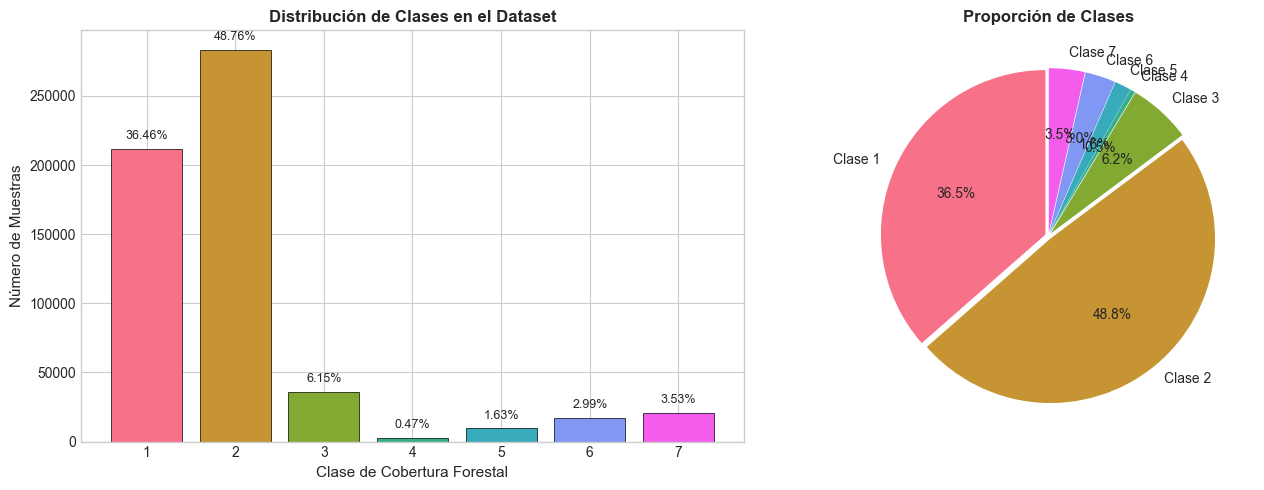


Ratio de desbalance (clase mayoritaria / clase minoritaria): 103.1x


In [6]:
# Visualización de la distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
colors = sns.color_palette('husl', n_colors=7)
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Clase de Cobertura Forestal', fontsize=11)
axes[0].set_ylabel('Número de Muestras', fontsize=11)
axes[0].set_title('Distribución de Clases en el Dataset', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(1, 8))

# Añadir etiquetas de porcentaje
for bar, pct in zip(bars, class_percentages.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                 f'{pct}%', ha='center', va='bottom', fontsize=9)

# Gráfico de pastel
axes[1].pie(class_counts.values, labels=[f'Clase {i}' for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, explode=[0.02]*7, startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis del desbalance
ratio = class_counts.max() / class_counts.min()
print(f'\nRatio de desbalance (clase mayoritaria / clase minoritaria): {ratio:.1f}x')

### 1.3 Distribución de Características Continuas

Analizaremos la distribución de las 10 características numéricas continuas para entender su comportamiento y detectar posibles outliers o transformaciones necesarias.

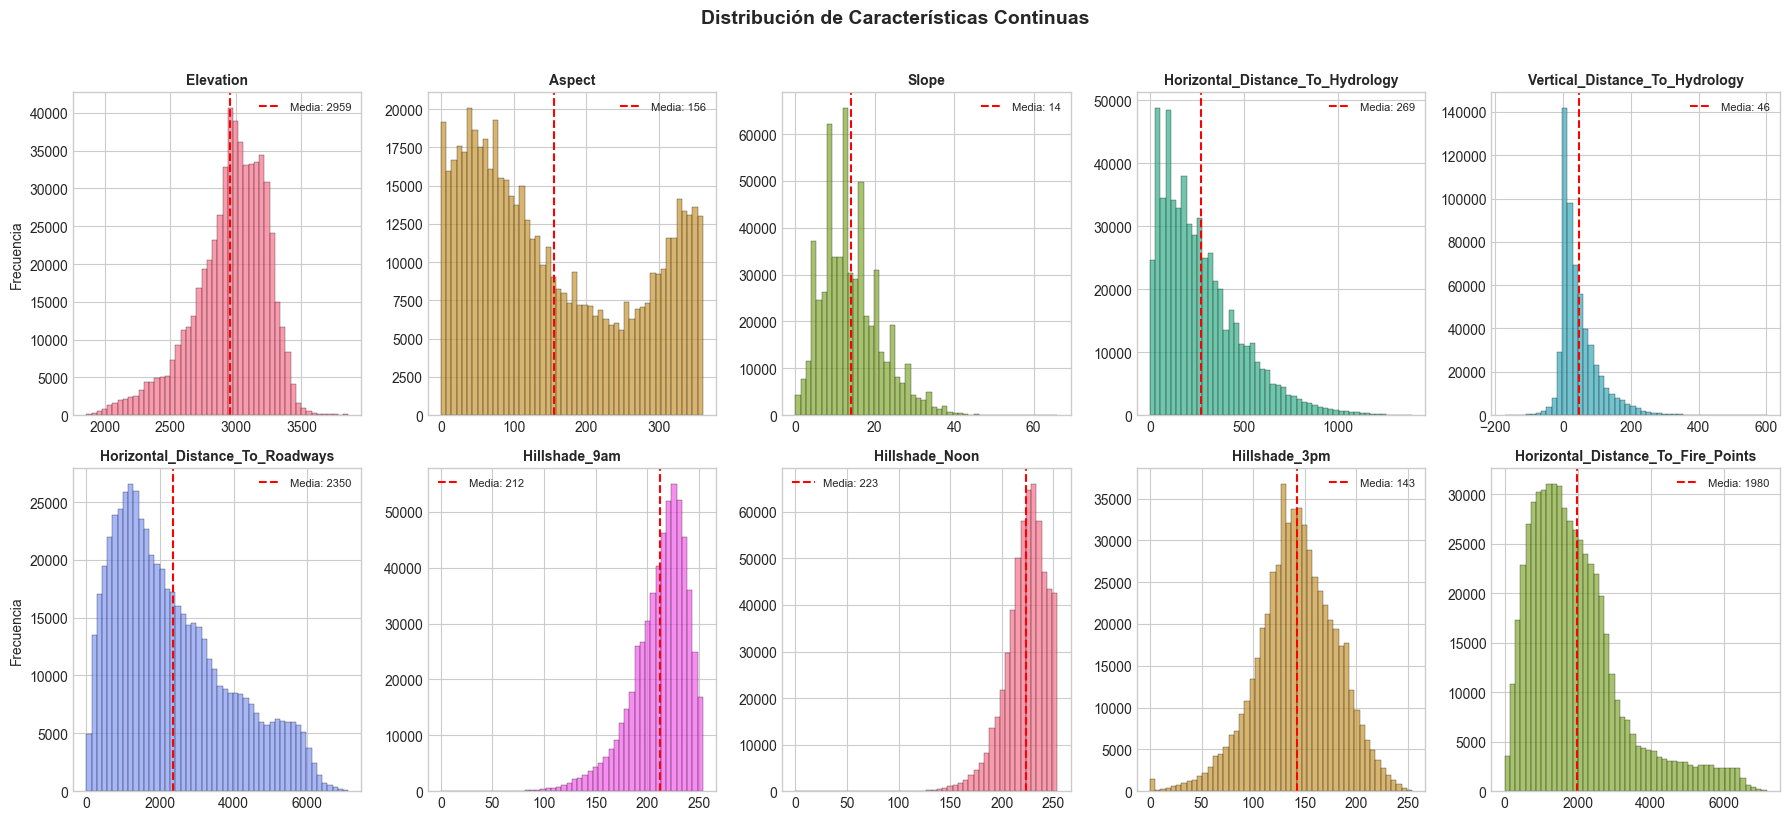

In [7]:
# Distribución de características continuas
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(continuous_features):
    axes[i].hist(X[col], bins=50, color=colors[i % 7], edgecolor='black', linewidth=0.3, alpha=0.7)
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia' if i % 5 == 0 else '')
    
    # Añadir línea de media
    mean_val = X[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Media: {mean_val:.0f}')
    axes[i].legend(fontsize=8)

plt.suptitle('Distribución de Características Continuas', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 1.4 Correlación entre Características

La matriz de correlación nos ayudará a identificar relaciones lineales entre variables y posible multicolinealidad que podría afectar el entrenamiento.

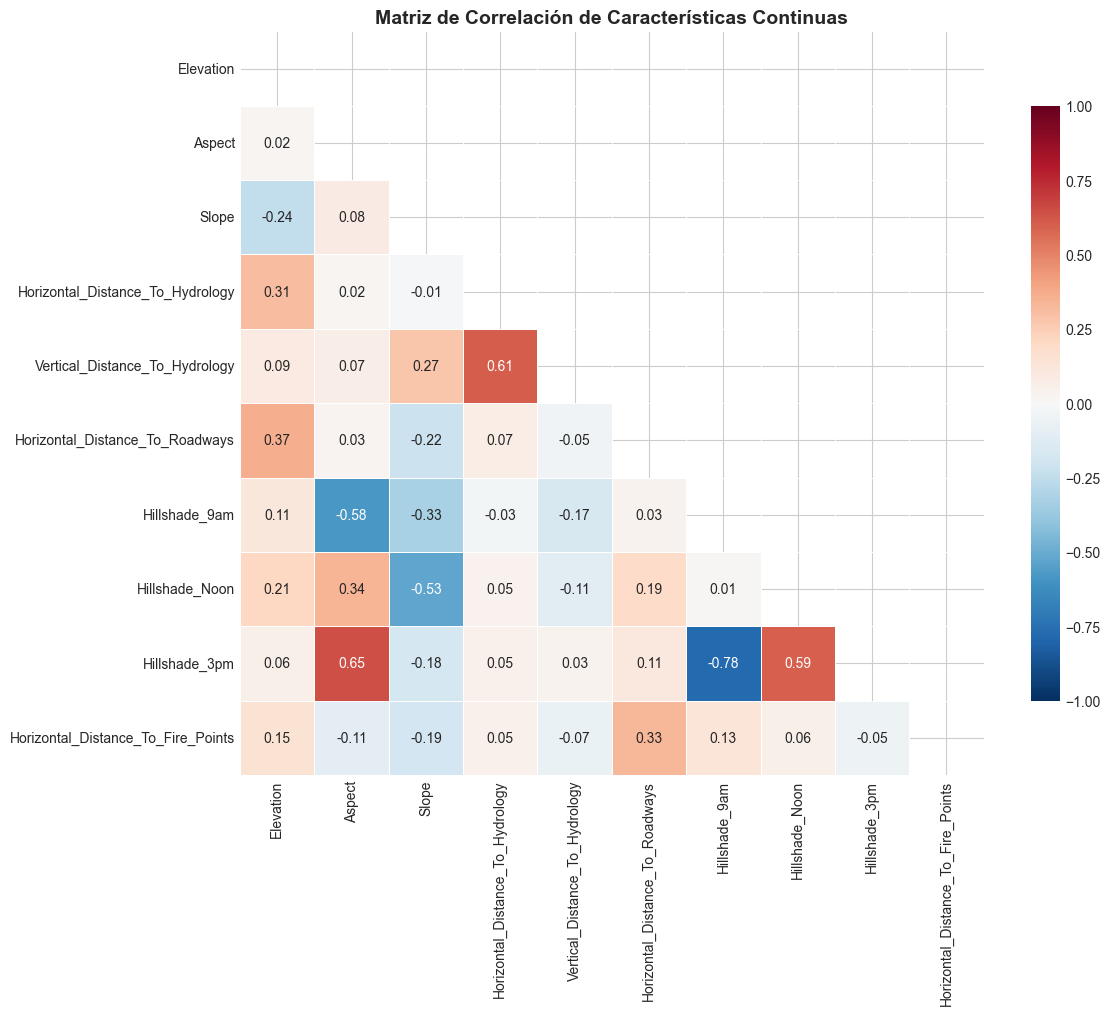

Correlaciones más fuertes (|r| > 0.5):
Aspect <-> Hillshade_9am: -0.579
Aspect <-> Hillshade_3pm: 0.647
Slope <-> Hillshade_Noon: -0.527
Horizontal_Distance_To_Hydrology <-> Vertical_Distance_To_Hydrology: 0.606
Hillshade_9am <-> Hillshade_3pm: -0.780
Hillshade_Noon <-> Hillshade_3pm: 0.594


In [8]:
# Matriz de correlación de características continuas
correlation_matrix = X[continuous_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Características Continuas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identificar correlaciones fuertes
print('Correlaciones más fuertes (|r| > 0.5):')
for i in range(len(continuous_features)):
    for j in range(i+1, len(continuous_features)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.5:
            print(f'{continuous_features[i]} <-> {continuous_features[j]}: {corr:.3f}')

## 2. Preprocesamiento de Datos

Antes de entrenar el modelo, debemos preparar los datos adecuadamente:

1. Convertir las etiquetas al rango [0, 6] en lugar de [1, 7] para compatibilidad con PyTorch
2. Dividir en conjuntos de entrenamiento, validación y prueba
3. Escalar las características continuas usando StandardScaler
4. Mantener las características binarias sin escalar (ya están en rango 0-1)

La división será 70% entrenamiento, 15% validación y 15% prueba.

In [9]:
# Convertir etiquetas al rango [0, 6]
y_adjusted = y - 1

print('Ajuste de etiquetas:')
print(f'Rango original: [{y.min()}, {y.max()}]')
print(f'Rango ajustado: [{y_adjusted.min()}, {y_adjusted.max()}]')

# División de datos: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_adjusted, test_size=0.15, random_state=42, stratify=y_adjusted
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 de 0.85 ≈ 0.15 del total
)

print(f'\nDivisión de datos:')
print(f'Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Validación: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)')
print(f'Prueba: {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)')

Ajuste de etiquetas:
Rango original: [1, 7]
Rango ajustado: [0, 6]

División de datos:
Entrenamiento: 406,940 muestras (70.0%)
Validación: 86,920 muestras (15.0%)
Prueba: 87,152 muestras (15.0%)
